In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import math

from scipy.stats import gamma, lognorm, norm, expon, poisson
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF

from IPython.display import display

# **Getting the Data**

In [ ]:
!wget https://raw.githubusercontent.com/DavideValentini/prodottiAssicurativi_danni/refs/heads/main/losses.txt

--2025-01-08 10:08:27--  https://raw.githubusercontent.com/DavideValentini/prodottiAssicurativi_danni/refs/heads/main/losses.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 465095 (454K) [text/plain]
Saving to: ‘losses.txt’

losses.txt          100%[===================>] 454.19K  --.-KB/s    in 0.01s   

2025-01-08 10:08:27 (41.9 MB/s) - ‘losses.txt’ saved [465095/465095]



In [ ]:
losses = []

with open("losses.txt", "r") as file:
    for line in file:
        losses.append(round(float(line.strip()),2)) #ad ogni riga tolgo il "newLine", converto la stringa in float e poi arrotondo alla seconda cifra decimale

time = [i for i in range(len(losses))]
losses = np.array(losses)

# **Main descriptive statistics**

In [ ]:
mean_loss = round(losses.mean(),2)
std_loss = round(losses.std(),2)
Q1_loss = round(np.percentile(losses, 25),2)
median_loss = round(np.percentile(losses, 50),2)
Q3_loss = round(np.percentile(losses, 75),2)
min_loss = round(losses.min(),2)
max_loss = round(losses.max(),2)
total_loss = round(losses.sum(),2)

summary = {
    'Statistic':['Mean', 'Standard deviation', '25th-perc', 'median', '75th-percentile', 'min values', 'max value', 'total loss'],
    'Value':[mean_loss, std_loss, Q1_loss, median_loss, Q3_loss, min_loss, max_loss, total_loss]
}


df_summary = pd.DataFrame(summary)
display(df_summary)

,Statistic,Value
0,Mean,8.056050e+03
1,Standard deviation,1.635011e+04
2,25th-perc,1.850780e+03
3,median,6.203220e+03
4,75th-percentile,7.408460e+03
5,min values,2.760000e+01
6,max value,3.163626e+05
7,total loss,2.094572e+08


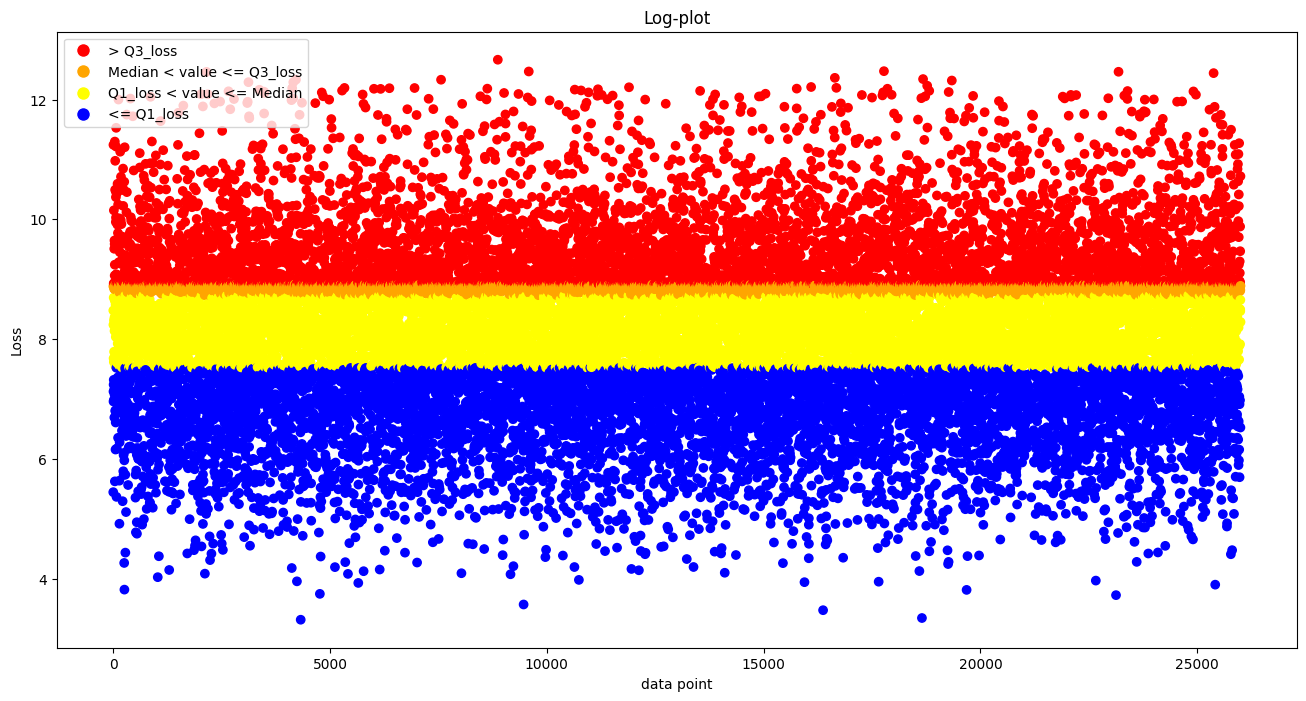

In [ ]:
#majority = [i for i in losses if Q1_loss < i < Q3_loss]
colors = [
    'red' if value > Q3_loss
    else 'orange' if value > median_loss
    else 'yellow' if value > Q1_loss
    else 'blue'  # Default color for values below Q1_loss
    for value in losses
]
log_loss = np.log(losses)

plt.figure(figsize=(16,8))
plt.scatter(time ,log_loss , c=colors)
plt.title('Log-plot')
plt.xlabel('data point')
plt.ylabel('Loss')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='> Q3_loss', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Median < value <= Q3_loss', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Q1_loss < value <= Median', markerfacecolor='yellow', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='<= Q1_loss', markerfacecolor='blue', markersize=10)
]

plt.legend(handles=legend_elements, loc='upper left')
plt.show()

# **Empiric distribution graph**

**Rice rule**

In [ ]:
int(2 * (len(losses) ** (1/3)))

59

Scott's Rule

In [ ]:
bin_width = 3.5 * np.std(losses) / (len(losses) ** (1/3))
int((max_loss - min_loss) / bin_width)

163

In [ ]:
#Empirical loss size index and mean excess function
x = np.sort(losses)
F = np.arange(1, len(x) + 1) / len(x)



Ix = np.zeros(len(x))
E = np.zeros(len(x))
for i in range(len(x)):
    Ind = x <= x[i]
    Ix[i] = np.mean(x * Ind) / np.mean(x)
    E[i] = np.mean((x - x[i]) * (x > x[i]))


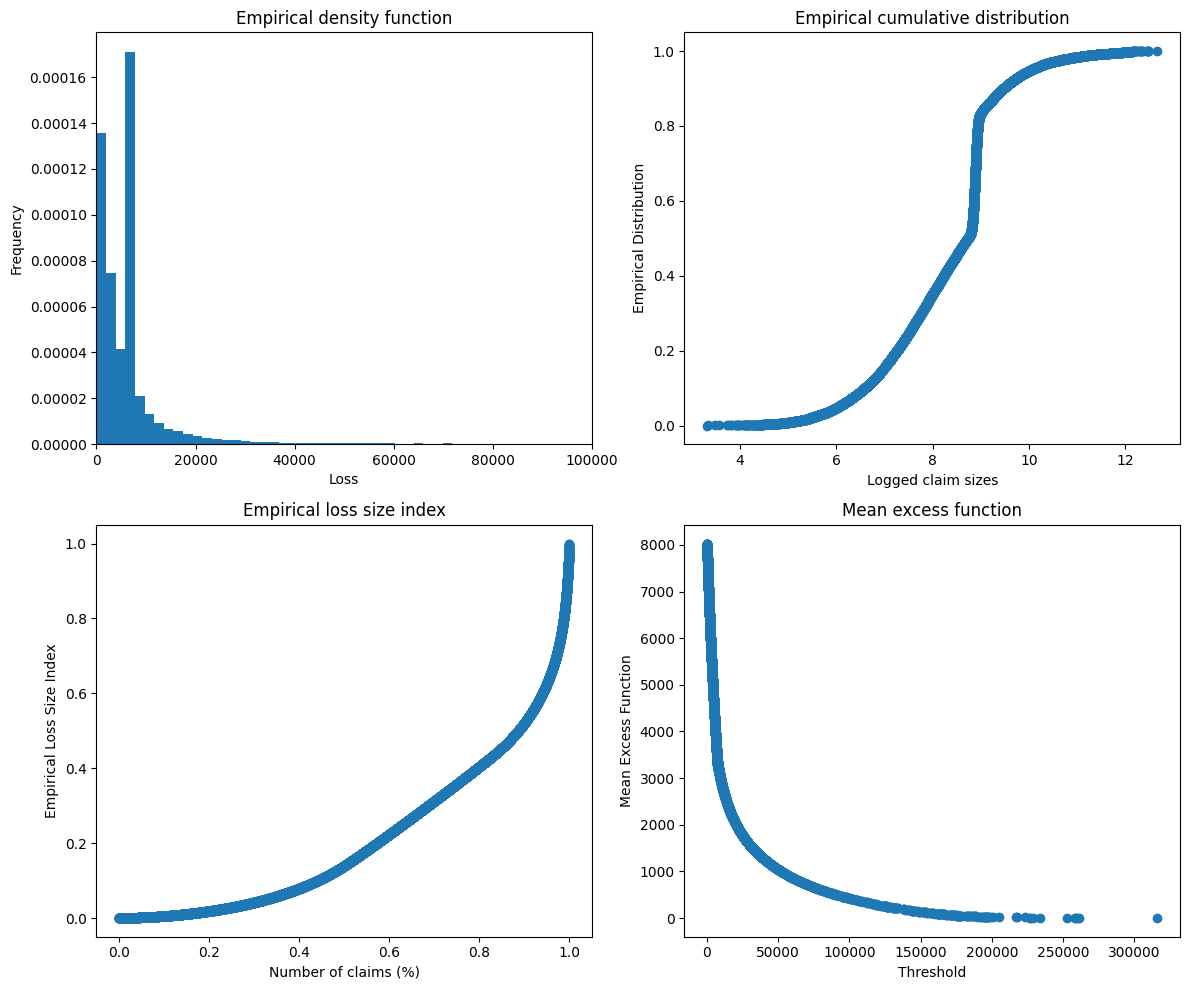

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(losses, bins=163, density=True)
axes[0,0].set_xlabel('Loss')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Empirical density function')
axes[0, 0].set_xlim([0, 100000])


axes[0,1].scatter(np.log(x), F)
axes[0,1].set_xlabel('Logged claim sizes')
axes[0,1].set_ylabel('Empirical Distribution')
axes[0,1].set_title('Empirical cumulative distribution')


axes[1,0].scatter(F, Ix)
axes[1,0].set_xlabel('Number of claims (%)')
axes[1,0].set_ylabel('Empirical Loss Size Index')
axes[1,0].set_title('Empirical loss size index')


axes[1,1].scatter(x, E)
axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('Mean Excess Function')
axes[1,1].set_title('Mean excess function')

plt.tight_layout()
plt.show()

# *Gamma and logNomrmal parameters estimation through maximum likelyhood *

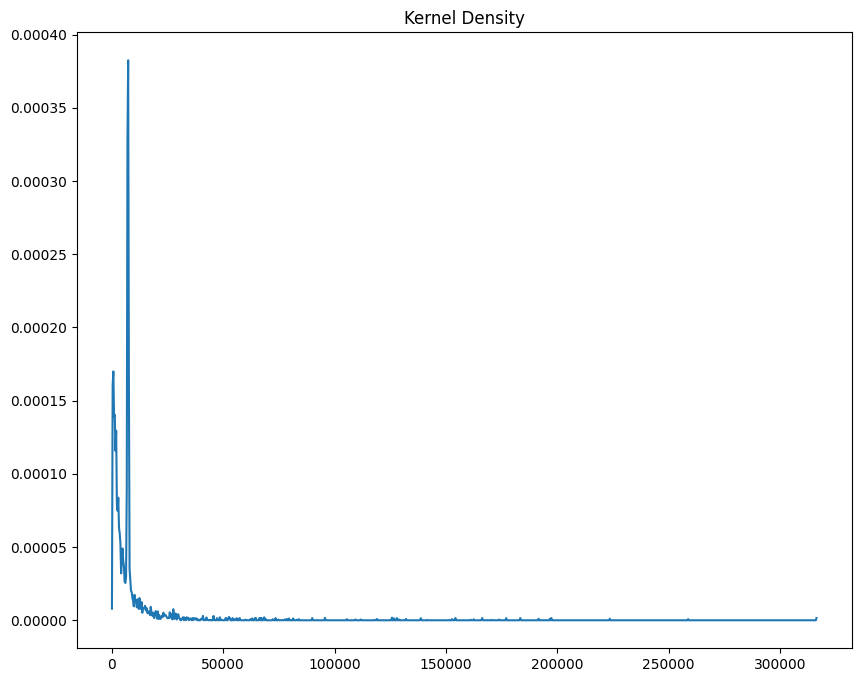

In [ ]:
# Densità Kernel
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(losses[:, None])
X_dens = np.linspace(min_loss, max_loss, 1000)[:, None]
log_dens = kde.score_samples(X_dens)

plt.figure(figsize=(10,8))
plt.plot(X_dens, np.exp(log_dens))
plt.title('Kernel Density')
plt.show()

**Gamma and LogNormal distribution estimation**

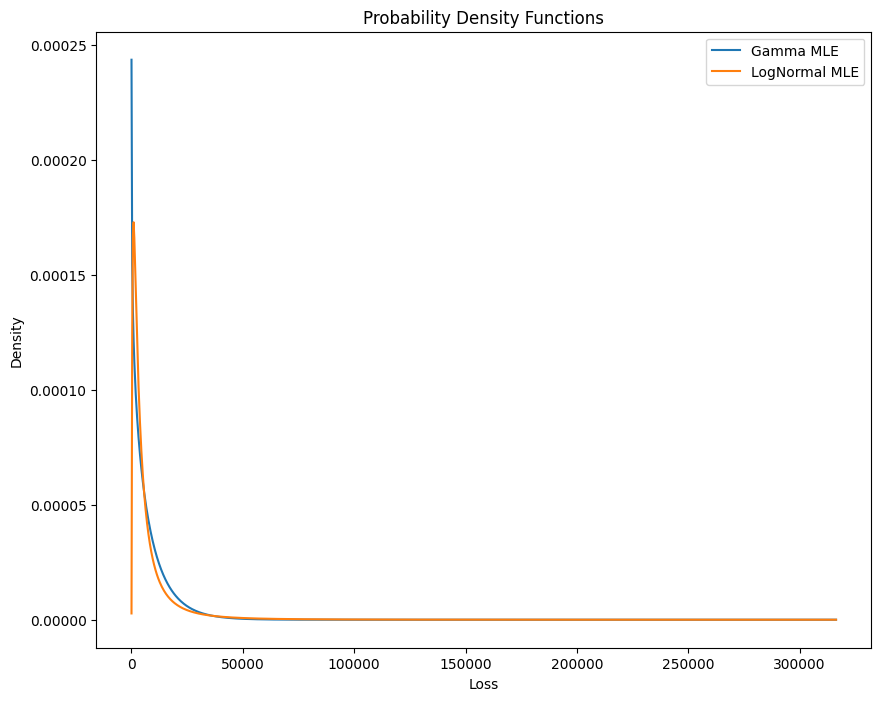

In [ ]:
# Gamma mle
params_gamma = gamma.fit(losses, floc=0)
LL_Gamma = np.sum(np.log(gamma.pdf(losses, *params_gamma)))

# Lognorm mle
params_lognorm = lognorm.fit(losses, floc=0)
LL_Logn = np.sum(np.log(lognorm.pdf(losses, *params_lognorm)))


# Traccia le distribuzioni stimate
x_vals = np.linspace(min_loss, max_loss, 1000)

plt.figure(figsize=(10,8))
plt.plot(x_vals, gamma.pdf(x_vals, *params_gamma), label='Gamma MLE')
plt.plot(x_vals, lognorm.pdf(x_vals, *params_lognorm), label='LogNormal MLE')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Probability Density Functions')
plt.legend()
plt.show()

**Goodness of the fit**

In [ ]:
# Kolmogorov-Smirnov test
from scipy.stats import kstest

h1 = kstest(losses, 'gamma', args=params_gamma)
h2 = kstest(losses, 'lognorm', args=params_lognorm)

# AIC e BIC
AIC_Gamma = 2 * 2 - 2 * LL_Gamma
AIC_Logn = 2 * 2 - 2 * LL_Logn

BIC_Gamma = 2 * np.log(len(losses)) - 2 * LL_Gamma
BIC_Logn = 2 * np.log(len(losses)) - 2 * LL_Logn

print( h1)
print( h2,'\n')

print('AIC Gamma: ',AIC_Gamma.round(2))
print('AIC LogNormal: ',AIC_Logn.round(2),'\n')

print('BIC Gamma: ',BIC_Gamma.round(2))
print('BIC LogNormal: ',BIC_Logn.round(2),'\n')

print('LogNormal parameters:\n')
print('Sigma  ',params_lognorm[0].round(2))
print('log scale',np.log(params_lognorm[2]).round(2))

KstestResult(statistic=0.19039311469046138, pvalue=0.0, statistic_location=7919.63, statistic_sign=1)
KstestResult(statistic=0.1483313361632237, pvalue=0.0, statistic_location=6552.46, statistic_sign=-1) 

AIC Gamma:  519086.57
AIC LogNormal:  514651.26 

BIC Gamma:  519102.91
BIC LogNormal:  514667.6 

LogNormal parameters:

Sigma   1.21
log scale 8.28


# **MonteCarlo Casinò Royale**

**MonteCarlo for the empirical cumulative distribution**

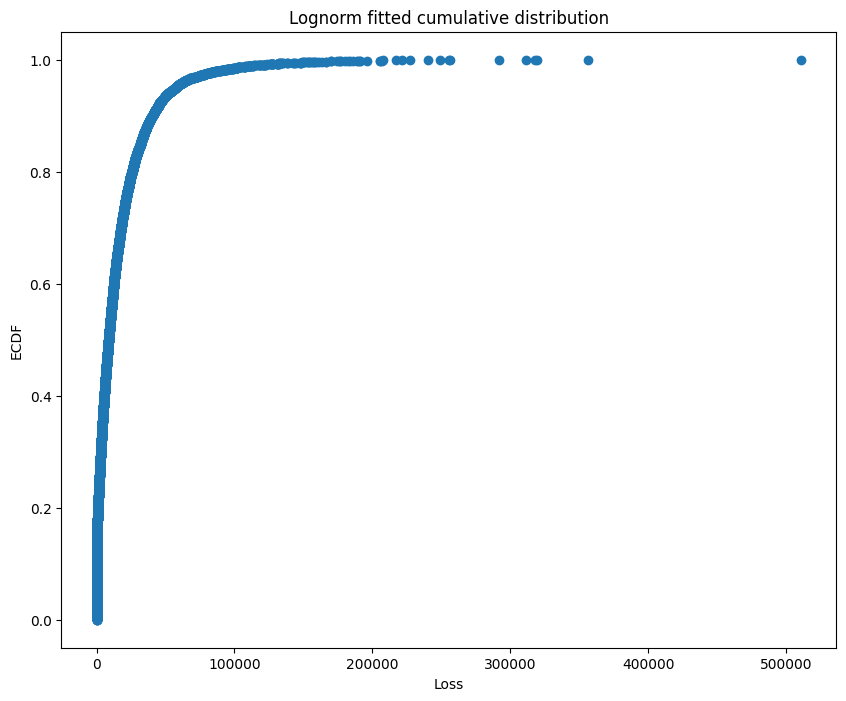

In [ ]:
# Simulazione Monte Carlo per il portafoglio di polizze
r=8; p=0.8; #negative binomial parameters
n = 10000

Nsin =np.random.negative_binomial(r, p, size=n) #I generage for 10000 times a negative binomial
Loss = np.zeros(n)

for i in range(n):
    Loss[i] = np.sum(lognorm.rvs(params_lognorm[0],loc=0, scale = params_lognorm[2], size=Nsin[i])) #I'm generating at each interaction n lognorm with that parametes and summing up all them

ecdf = ECDF(Loss)
plt.figure(figsize=(10,8))
plt.scatter(ecdf.x, ecdf.y)
plt.title('Lognorm fitted cumulative distribution')
plt.xlabel('Loss')
plt.ylabel('ECDF')
plt.show()


**Fair price through MonteCarlo**

a lot of monte carlo simulations and then we take the mean, it should be near the product of the lognormal mean and negative binomial mean

In [ ]:
n = 10000
Nsin =np.random.negative_binomial(r, p, size=n)
Loss = np.zeros(n)
r=8; p=0.8; #negative binomial parameters
Nsin =np.random.negative_binomial(r, p, size=n)

for i in range(n):
  Loss[i] = np.sum(lognorm.rvs(params_lognorm[0],loc=0, scale = params_lognorm[2], size=Nsin[i]))

fairPrice = np.mean(Loss)


E_sin = r*(1-p)/p
E_singularLoss =lognorm.mean(s=params_lognorm[0], scale=params_lognorm[2])
ES = E_sin*E_singularLoss


print('Observed fair price of the policy through MonteCarlo: ',fairPrice.round(2),'\n')
print('Theoretical fair price: ', ES.round(2))

Observed fair price of the policy through MonteCarlo:  16682.61 

Theoretical fair price:  16547.23


**Percentile pricing**

In [ ]:
alpha = 0.99

premium_var99 = lognorm.ppf(alpha,s = params_lognorm[0], scale = params_lognorm[2])
print('Pure 99-th percentile price: ', premium_var99.round(2))

Pure 99-th percentile price:  66657.97


In [ ]:
rCoC = 0.09

alpha=0.95
var_95 = lognorm.ppf(alpha,s = params_lognorm[0], scale = params_lognorm[2])
premium_95 = ES + rCoC*(var_95-ES)

print('Pure price through 95th percentile method: ', premium_95.round(2),'\n')

alpha=0.99
var_99 = lognorm.ppf(alpha,s = params_lognorm[0], scale = params_lognorm[2])
premium_99 = ES + rCoC*(var_99-ES)

print('Pure price through 99th percentile method: ', premium_99.round(2),'\n')

alpha=0.995
var_995 = lognorm.ppf(alpha, s = params_lognorm[0], scale = params_lognorm[2])
premium_995 = ES + rCoC*(var_995-ES)

print('Pure price through 99.5th percentile method: ', premium_995.round(2),'\n')

Pure price through 95th percentile method:  17682.18 

Pure price through 99th percentile method:  21057.19 

Pure price through 99.5th percentile method:  23177.92 



# **BootsTrap maaaaaan**

Observed fair price of the policy through Bootstrap:  15822.88


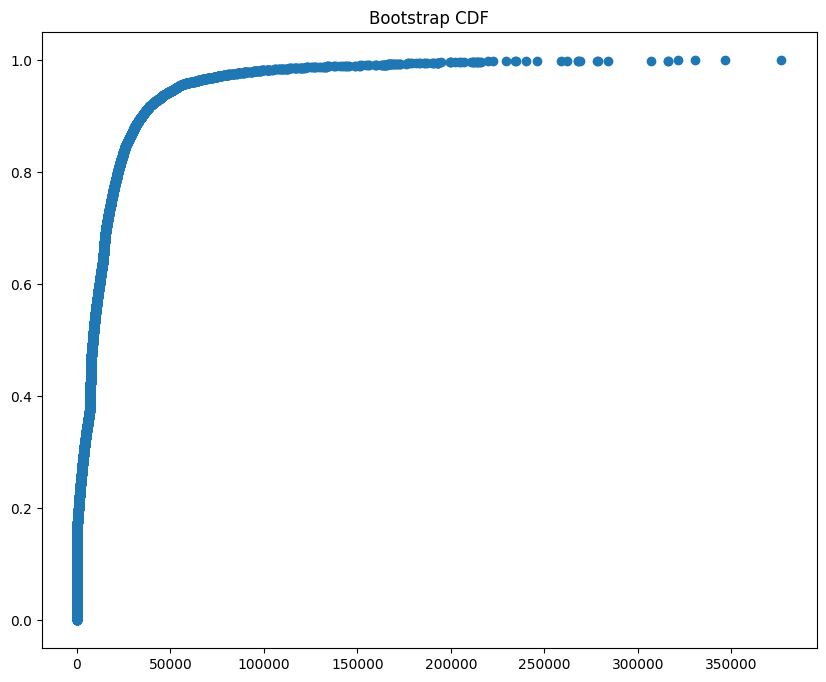

In [ ]:
# Metodo Bootstrap

r=8; p=0.8; #negative binomial parameters
n=10000
Nsin =np.random.negative_binomial(r, p, size=n)

Loss = np.zeros(n)
for i in range(n):
    Loss[i] = np.sum(np.random.choice(losses, Nsin[i], replace=True)) #get Nsin[i] "items" from losses

fairPrice = np.mean(Loss)
print('Observed fair price of the policy through Bootstrap: ',fairPrice.round(2))


# Visualizzazione della CDF bootstrap
ecdf_b = ECDF(Loss)
plt.figure(figsize=(10,8))
plt.scatter(ecdf_b.x, ecdf_b.y)
plt.title('Bootstrap CDF')
plt.show()


# **Solvibility**

In [ ]:
num_policies = 5000

initialProfit_perc99 = num_policies*premium_var99
initialProfit_95 = num_policies*premium_95
initialProfit_99 = num_policies*premium_99
initialProfit_995 = num_policies*premium_995

n_trials = 5000000
Loss = 0

r=8
p=0.8

ruin_perc99 = np.zeros(n_trials)
ruin_95 = np.zeros(n_trials)
ruin_99 = np.zeros(n_trials)
ruin_995 = np.zeros(n_trials)

for i in range(n_trials):

  Nsin = np.random.negative_binomial(r, p, size=1)
  Loss = sum(lognorm.rvs(params_lognorm[0],loc=0, scale = params_lognorm[2], size=Nsin))

  if Loss > initialProfit_perc99:
    ruin_perc99[i] = 1

  if Loss > initialProfit_95:
    ruin_95[i] = 1

  if Loss > initialProfit_99:
    ruin_99[i] = 1

  if Loss > initialProfit_995:
    ruin_995[i] = 1


solvibility_perc99 = (sum(ruin_perc99) / n_trials)*100
solvibility_95 = (sum(ruin_95) / n_trials)*100
solvibility_99 = (sum(ruin_99) / n_trials)*100
solvibility_995 = (sum(ruin_995) / n_trials)*100

print('With a premium priced with the rCoC and 95th percentile method the probability of failure is: ',(solvibility_95*100))
print('With a premium priced with the rCoC and 99th percentile method the probability of failure is: ',(solvibility_99*100))
print('With a premium priced with the rCoC and 99.5th percentile method the probability of failure is: ',(solvibility_995*100))
print('With a premium priced with the 99 percentile method the probability of failure is: ',(solvibility_perc99*100).round(4))

With a premium priced with the rCoC and 95th percentile method the probability of failure is:  0.0
With a premium priced with the rCoC and 99th percentile method the probability of failure is:  0.0
With a premium priced with the rCoC and 99.5th percentile method the probability of failure is:  0.0
With a premium priced with the 99 percentile method the probability of failure is:  0.0


# **RIASSICURAZIONE**

In [ ]:
# Bootstrap for re-insurer fair price

alpha = 0.97
var_97 = lognorm.ppf(alpha,s = params_lognorm[0], scale = params_lognorm[2]) #All losses above 97-th percentile go to the re-insurer

n=10000

r=8; p=0.8;
Nsin =np.random.negative_binomial(r, p, size=n)

riass_Loss = np.zeros(n)

for i in range(n):

  random_loss = np.random.choice(losses, Nsin[i], replace=True) # I gen Nsin[i] losses from the real one happened.
  Loss = []

  for j in range(len(random_loss)):

    if random_loss[j] >= var_97:
      Loss.append(random_loss[j])

  riass_Loss[i] = sum(Loss)

riass_fairPrice = np.mean(riass_Loss)
print('Observed fair price of the policy through Bootstrap: ',riass_fairPrice.round(2))

Observed fair price of the policy through Bootstrap:  4855.48


In [ ]:
k = 0.25
premium_riass = riass_fairPrice + k*riass_fairPrice
print('The company premium established by the reinsurer with a 0.25 charge is: ',premium_riass.round(2))

The company premium established by the reinsurer with a 0.25 charge is:  6069.35


In [ ]:
#tolgo robe
for i in range(len(losses)):

  if losses[i] >= var_97:
    losses[i] = var_97

losses_riass = np.append(losses, premium_riass)

In [ ]:
#Empirical loss size index and mean excess function
x = np.sort(losses_riass)
F = np.arange(1, len(x) + 1) / len(x)



Ix = np.zeros(len(x))
E = np.zeros(len(x))
for i in range(len(x)):
    Ind = x <= x[i]
    Ix[i] = np.mean(x * Ind) / np.mean(x)
    E[i] = np.mean((x - x[i]) * (x > x[i]))

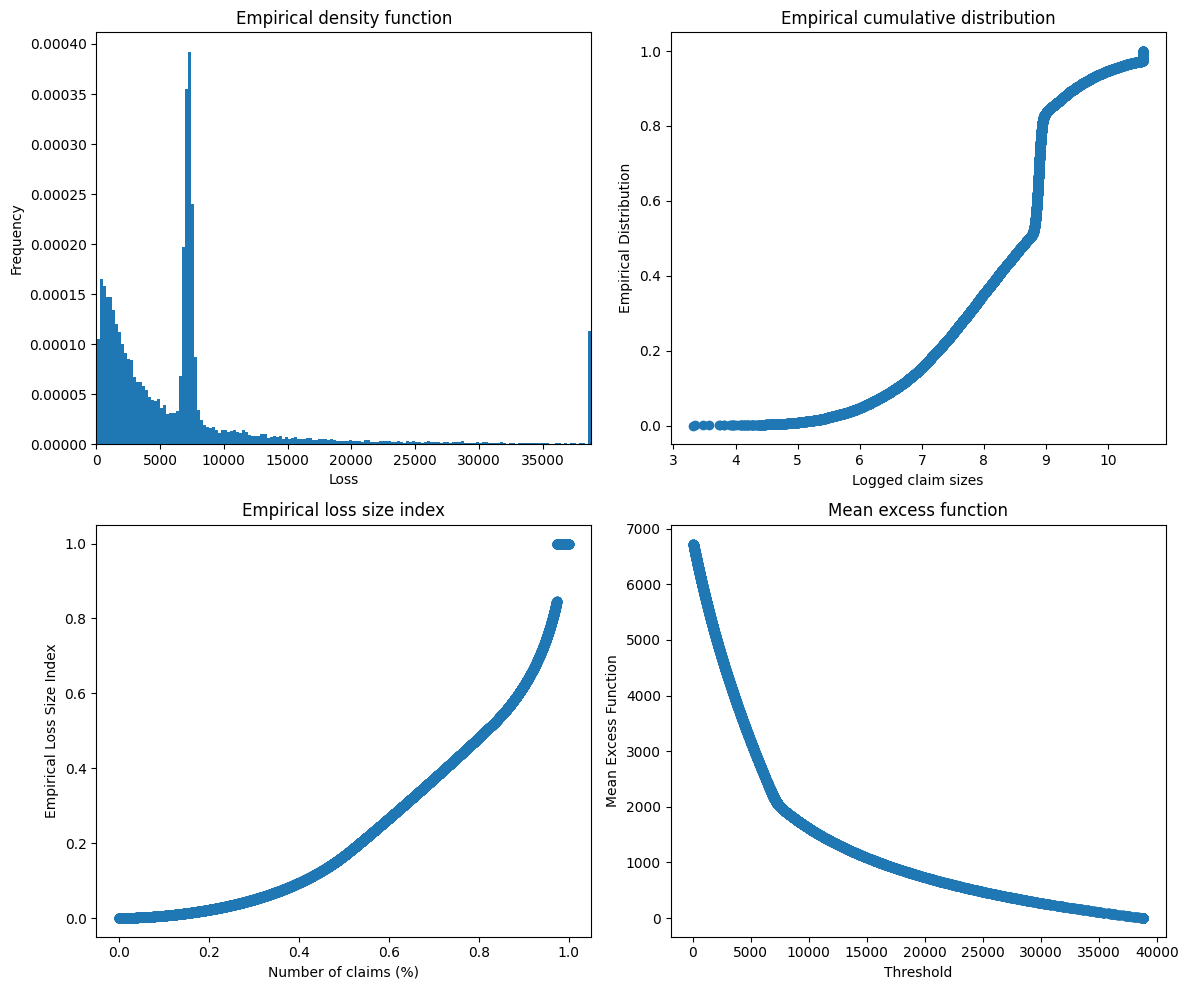

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(losses_riass, bins=163, density=True)
axes[0,0].set_xlabel('Loss')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Empirical density function')
axes[0, 0].set_xlim([0, losses_riass.max()])


axes[0,1].scatter(np.log(x), F)
axes[0,1].set_xlabel('Logged claim sizes')
axes[0,1].set_ylabel('Empirical Distribution')
axes[0,1].set_title('Empirical cumulative distribution')


axes[1,0].scatter(F, Ix)
axes[1,0].set_xlabel('Number of claims (%)')
axes[1,0].set_ylabel('Empirical Loss Size Index')
axes[1,0].set_title('Empirical loss size index')


axes[1,1].scatter(x, E)
axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('Mean Excess Function')
axes[1,1].set_title('Mean excess function')

plt.tight_layout()
plt.show()